<a href="https://colab.research.google.com/github/Kurniawan00/Absen_BSG/blob/main/Pengelolaan_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>>> Status: Mencari dan Memuat Data...
✅ Data Berhasil Dimuat. Ukuran: (307511, 122)
>>> Status: Melakukan Feature Engineering...
>>> Status: Membuat Visualisasi Data...


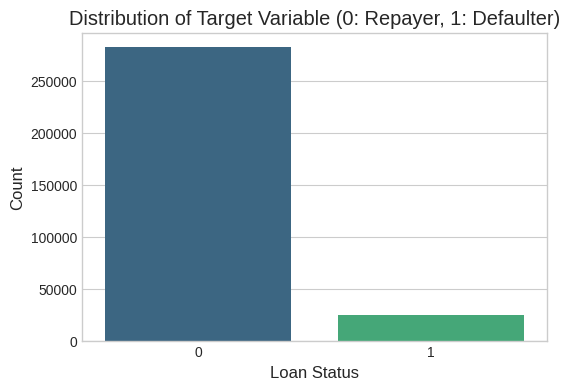

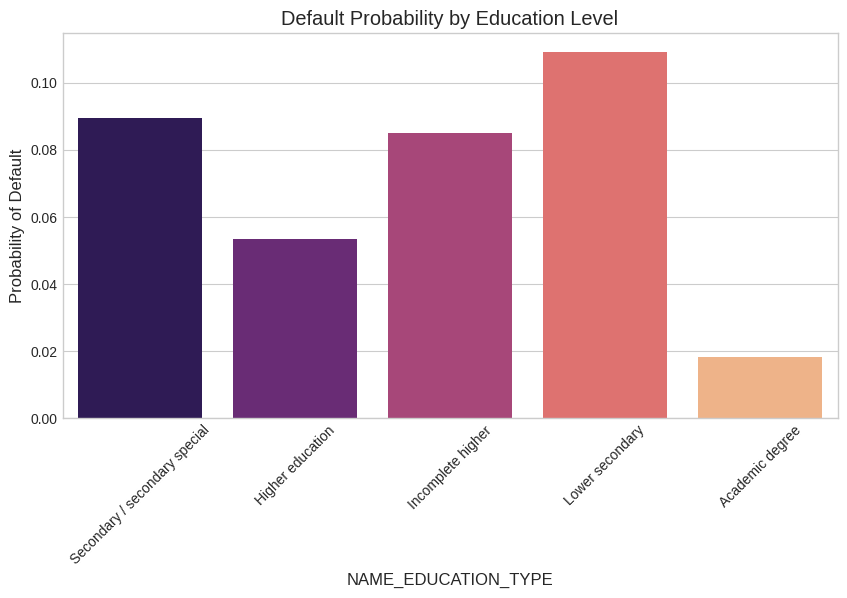

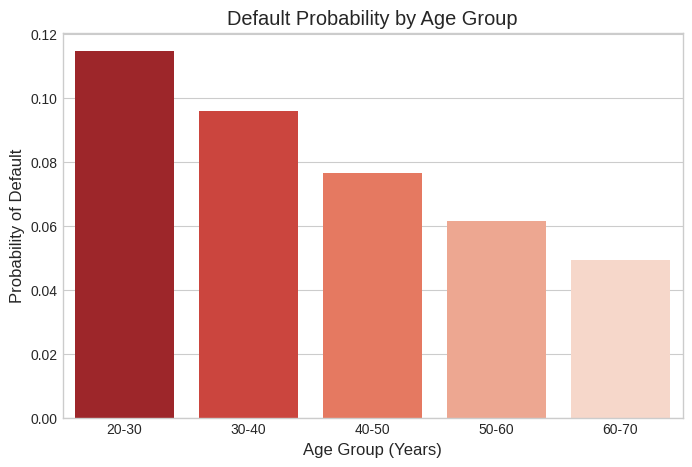

>>> Status: Menyiapkan Data untuk Modeling...
>>> Status: Melatih Model Machine Learning...
✅ Model Berhasil Dilatih.
>>> Status: Evaluasi Performa Model...

=== MODEL PERFORMANCE REPORT ===
ROC AUC Score: 0.6172


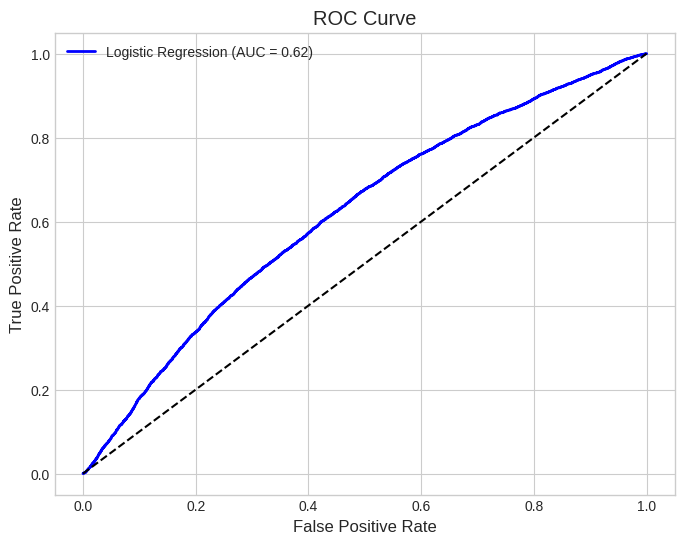

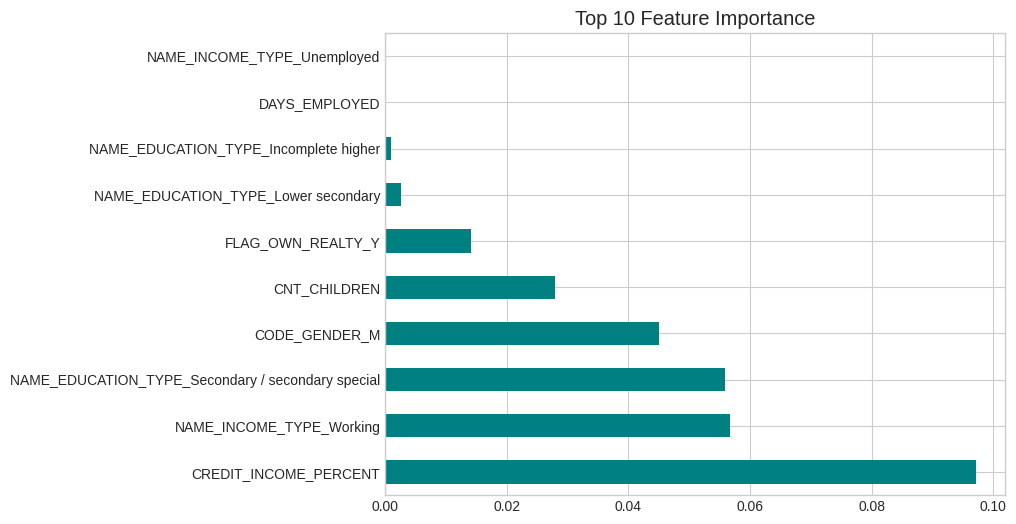


>>> PROSES SELESAI.


In [6]:
# ==============================================================================
# PROJECT: Home Credit Default Risk Prediction
# DESCRIPTION: End-to-End Machine Learning Pipeline
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Library Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report

# Konfigurasi Tampilan
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# --- 1. DATA LOADING & SEARCH ---
print(">>> Status: Mencari dan Memuat Data...")
filename = 'application_train.csv'
file_path = None

# Mencari file secara otomatis
for root, dirs, files in os.walk('.'):
    if filename in files:
        file_path = os.path.join(root, filename)
        break

if file_path is None:
    print(f"❌ Error: File '{filename}' tidak ditemukan. Harap upload file terlebih dahulu.")
else:
    df = pd.read_csv(file_path)
    print(f"✅ Data Berhasil Dimuat. Ukuran: {df.shape}")

    # --- 2. FEATURE ENGINEERING & CLEANING ---
    print(">>> Status: Melakukan Feature Engineering...")

    # A. Handling Anomaly (DAYS_EMPLOYED)
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    # B. Membuat Fitur Baru (Domain Knowledge)
    # 1. Konversi Umur (Hari ke Tahun) & Kelompok Umur
    df['AGE_YEARS'] = df['DAYS_BIRTH'] / -365
    df['AGE_GROUP'] = pd.cut(df['AGE_YEARS'],
                             bins=[20, 30, 40, 50, 60, 70],
                             labels=['20-30', '30-40', '40-50', '50-60', '60-70'])

    # 2. Rasio Kredit terhadap Pendapatan
    df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

    # --- 3. EXPLORATORY DATA ANALYSIS (EDA) ---
    print(">>> Status: Membuat Visualisasi Data...")

    # Visualisasi 1: Distribusi Target
    plt.figure(figsize=(6, 4))
    sns.countplot(x='TARGET', data=df, palette='viridis')
    plt.title('Distribution of Target Variable (0: Repayer, 1: Defaulter)')
    plt.xlabel('Loan Status')
    plt.ylabel('Count')
    plt.show()

    # Visualisasi 2: Risiko Berdasarkan Pendidikan
    plt.figure(figsize=(10, 5))
    sns.barplot(x='NAME_EDUCATION_TYPE', y='TARGET', data=df, ci=None, palette='magma')
    plt.title('Default Probability by Education Level')
    plt.xticks(rotation=45)
    plt.ylabel('Probability of Default')
    plt.show()

    # Visualisasi 3: Risiko Berdasarkan Umur
    plt.figure(figsize=(8, 5))
    age_risk = df.groupby('AGE_GROUP')['TARGET'].mean().reset_index()
    sns.barplot(x='AGE_GROUP', y='TARGET', data=age_risk, palette='Reds_r')
    plt.title('Default Probability by Age Group')
    plt.xlabel('Age Group (Years)')
    plt.ylabel('Probability of Default')
    plt.show()

    # --- 4. DATA PREPARATION FOR MODELING ---
    print(">>> Status: Menyiapkan Data untuk Modeling...")

    # Seleksi Fitur Utama
    features = ['TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
                'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CREDIT_INCOME_PERCENT']

    # Filter kolom yang tersedia
    available_feats = [f for f in features if f in df.columns]
    data_model = df[available_feats].copy()

    # Pisahkan X dan y
    X = data_model.drop('TARGET', axis=1)
    y = data_model['TARGET']

    # Imputasi (Mengisi Data Kosong)
    num_cols = X.select_dtypes(include=['number']).columns
    cat_cols = X.select_dtypes(include=['object']).columns

    imputer_num = SimpleImputer(strategy='median')
    X[num_cols] = imputer_num.fit_transform(X[num_cols])

    imputer_cat = SimpleImputer(strategy='most_frequent')
    X[cat_cols] = imputer_cat.fit_transform(X[cat_cols])

    # Encoding (Kategorikal ke Numerik)
    X = pd.get_dummies(X, drop_first=True)

    # --- 5. MODELING (LOGISTIC REGRESSION) ---
    print(">>> Status: Melatih Model Machine Learning...")

    # Split Data (80% Train, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Training Model
    # class_weight='balanced' untuk menangani data imbalance
    model = LogisticRegression(class_weight='balanced', solver='liblinear', C=0.01, random_state=42)
    model.fit(X_train, y_train)
    print("✅ Model Berhasil Dilatih.")

    # --- 6. EVALUATION ---
    print(">>> Status: Evaluasi Performa Model...")

    # Prediksi
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Hitung Metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(f"\n=== MODEL PERFORMANCE REPORT ===")
    print(f"ROC AUC Score: {auc_score:.4f}")

    # Visualisasi 4: ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.2f})', color='blue', lw=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # Visualisasi 5: Feature Importance
    coeffs = pd.Series(model.coef_[0], index=X.columns)
    plt.figure(figsize=(8, 6))
    coeffs.sort_values(ascending=False).head(10).plot(kind='barh', color='teal')
    plt.title('Top 10 Feature Importance')
    plt.show()

    print("\n>>> PROSES SELESAI.")